In [25]:
!pip install wordcloud
!pip install spacy
!pip install textblob

In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Sentiment Analysis
from textblob import TextBlob

# Machine Learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [3]:
data = pd.read_csv('C:/Users/User/Socmed Computing/spotify reviews.csv')  

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61594 entries, 0 to 61593
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Time_submitted  61594 non-null  object
 1   Review          61594 non-null  object
 2   Rating          61594 non-null  int64 
 3   Total_thumbsup  61594 non-null  int64 
 4   Reply           216 non-null    object
dtypes: int64(2), object(3)
memory usage: 2.3+ MB


,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN


In [4]:
print(f'Number of records: {data.shape[0]}\nNumber of features: {data.shape[1]}')

Number of records: 61594
Number of features: 5


## Data Cleaning
Handle Missing Values and Duplicates

In [5]:
# Drop rows with missing reviews
data.dropna(subset=['Review'], inplace=True) 

# Drop duplicate reviews
data.drop_duplicates(subset=['Review'], inplace=True)

Drop Time_submitted and Reply columns.

In [6]:
print(data.columns)


Index(['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply'], dtype='object')


In [7]:
data.drop(['Time_submitted', 'Reply'], axis=1, inplace=True)
data.head()

,Review,Rating,Total_thumbsup
0,"Great music service, the audio is high quality...",5,2
1,Please ignore previous negative rating. This a...,5,1
2,"This pop-up ""Get the best Spotify experience o...",4,0
3,Really buggy and terrible to use as of recently,1,1
4,Dear Spotify why do I get songs that I didn't ...,1,1


## Exploratory Data Analysis (EDA)
Average number of thumbs up for each category rating

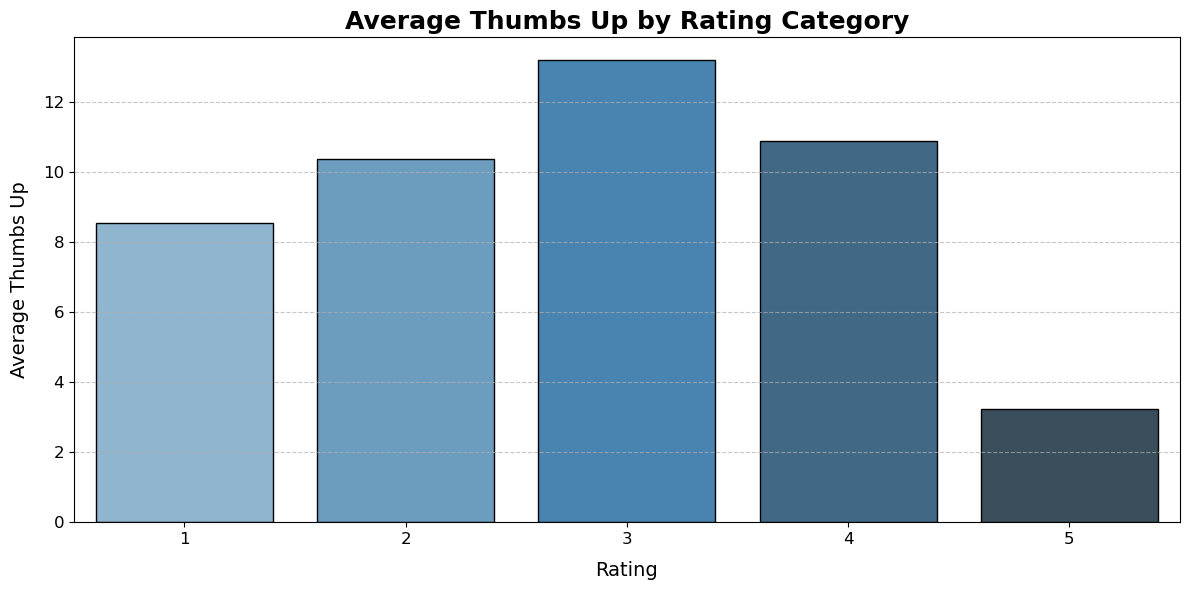

In [8]:
# Calculate the average number of thumbs up for each rating category
rating_thumb_avg = data.groupby('Rating')['Total_thumbsup'].mean().reset_index()


plt.figure(figsize=(12, 6))  
sns.barplot(
    x='Rating', 
    y='Total_thumbsup', 
    data=rating_thumb_avg, 
    palette='Blues_d', 
    edgecolor='black'
)


plt.title('Average Thumbs Up by Rating Category', fontsize=18, weight='bold')
plt.xlabel('Rating', fontsize=14, labelpad=10)
plt.ylabel('Average Thumbs Up', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) 


plt.tight_layout()
plt.show()


Length of Reviews

c:\Users\User\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


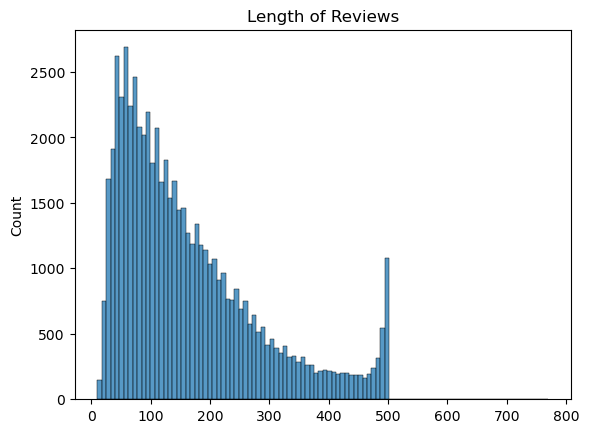

In [9]:
data['length'] = data['Review'].str.len()

sns.histplot(data['length'][data.length < 800])
plt.title('Length of Reviews')
plt.xlabel('')
plt.show()


## Text Preprocessing

Transform rating category to sentiment labels

In [10]:
def transform_ratings(rating):
    if rating == 5 or rating == 4:
        return "Good"
    elif rating == 3:
        return "Neutral"
    elif rating == 2 or rating == 1:
        return "Bad"
    else:
        return "Unknown"  # Handle unexpected values

data['sentiment'] = data['Rating'].apply(transform_ratings)

In [11]:
print(data['sentiment'].value_counts())

sentiment
Good       29762
Bad        24718
Neutral     6876
Name: count, dtype: int64


Apply text cleaning using textblob
1. convert to lowercase
2. tokenizing text into individual words
3. remove non-alphanumeric characters
4. lemmatizing the words

In [12]:
# Define text cleaning function 
def preprocess_text_textblob(text):
    blob = TextBlob(text.lower())  # Convert text to lowercase
    tokens = [word.lemmatize() for word in blob.words if word.isalnum()]
    return " ".join(tokens)

# Apply the function to the Review column
data['cleaned_review'] = data['Review'].apply(preprocess_text_textblob)
data.head()


,Review,Rating,Total_thumbsup,length,sentiment,cleaned_review
0,"Great music service, the audio is high quality...",5,2,112,Good,great music service the audio is high quality ...
1,Please ignore previous negative rating. This a...,5,1,86,Good,please ignore previous negative rating this ap...
2,"This pop-up ""Get the best Spotify experience o...",4,0,106,Good,this get the best spotify experience on androi...
3,Really buggy and terrible to use as of recently,1,1,47,Bad,really buggy and terrible to use a of recently
4,Dear Spotify why do I get songs that I didn't ...,1,1,100,Bad,dear spotify why do i get song that i did put ...


## Sentiment Analysis

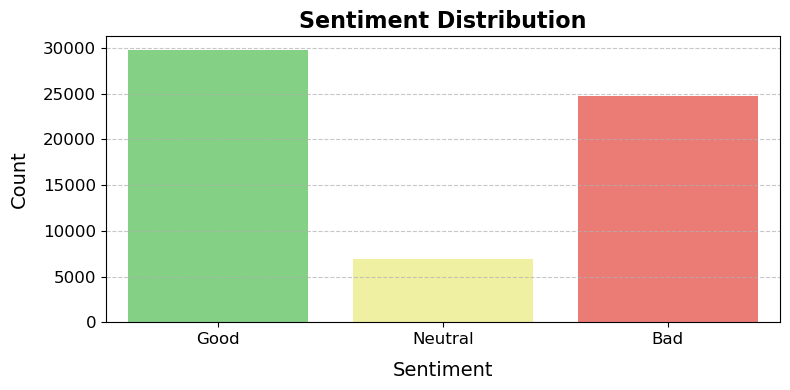

In [13]:
plt.figure(figsize=(8, 4))
sns.countplot(
    data=data, 
    x='sentiment', 
    order=['Good', 'Neutral', 'Bad'], 
    palette={'Good': '#77dd77', 'Neutral': '#fdfd96', 'Bad': '#ff6961'} 
)
plt.title('Sentiment Distribution', fontsize=16, weight='bold')
plt.xlabel('Sentiment', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()

## Machine Learning for Sentiment Analysis
Split data into testing and training subset

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_review'], data['sentiment'], test_size=0.2, random_state=42)

Apply TF-IDF Classification

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize text data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Random Forest Model

In [55]:
# Train and evaluate Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_vec, y_train)
y_pred_rf = rf_model.predict(X_test_vec)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

         Bad       0.71      0.88      0.78      4985
        Good       0.83      0.85      0.84      5936
     Neutral       0.25      0.00      0.00      1351

    accuracy                           0.77     12272
   macro avg       0.60      0.58      0.54     12272
weighted avg       0.72      0.77      0.73     12272



Naive Bayes Model

In [56]:
from sklearn.naive_bayes import MultinomialNB 

# Train and evaluate Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

# Compare model scores
from sklearn.metrics import accuracy_score

rf_accuracy = accuracy_score(y_test, y_pred_rf)
nb_accuracy = accuracy_score(y_test, y_pred_nb)

Naive Bayes Classification Report:
              precision    recall  f1-score   support

         Bad       0.71      0.88      0.79      4985
        Good       0.83      0.86      0.84      5936
     Neutral       0.00      0.00      0.00      1351

    accuracy                           0.77     12272
   macro avg       0.51      0.58      0.54     12272
weighted avg       0.69      0.77      0.73     12272



c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
rf_accuracy_rounded = round(rf_accuracy, 2)
nb_accuracy_rounded = round(nb_accuracy, 2)

# Print rounded accuracies
print(f"Random Forest Accuracy: {rf_accuracy_rounded:.2f}")
print(f"Naive Bayes Accuracy: {nb_accuracy_rounded:.2f}")

#Comparison between two models
if rf_accuracy_rounded > nb_accuracy_rounded:
    print("Random Forest performs better.")
elif nb_accuracy_rounded > rf_accuracy_rounded:
    print("Naive Bayes performs better.")
else:
    print("Both models perform equally.")


Random Forest Accuracy: 0.77
Naive Bayes Accuracy: 0.77
Both models perform equally.


In [65]:
# Save new csv file with sentiments column
data.to_csv('spotify_sentiment_analysis_results.csv', index=False)

## Prediction
Predict ratings categories using a model trained on reviews for Spotify from the Google Play Store

In [75]:
test_reviews = [
    'I am not a premium user, but the app is amazing.',
    'Wonderful app with great music recommendations for music but terrible for podcasts because of the ads',
    'Worthless app',
    'Good, but... I wish it had a toggle in settings for opting out of it will automatically playing upon connection to headphones or to car'
    ]

# Transform the test reviews using the same vectorizer used for training
test_reviews_vec = vectorizer.transform(test_reviews).toarray()

# Predict sentiment categories using the Naive Bayes model 
pred = nb_model.predict(test_reviews_vec)

# Convert the numerical predictions back to readable sentiment categories
pred_transformed = pred.tolist()

# Create a DataFrame to display the results
result = pd.DataFrame({
    'Reviews': test_reviews,
    'Predicted Rating': pred_transformed
})

# Display the result in the notebook
print(result)

                                             Reviews Predicted Rating
0   I am not a premium user, but the app is amazing.             Good
1  Wonderful app with great music recommendations...             Good
2                                      Worthless app              Bad
3  Good, but... I wish it had a toggle in setting...              Bad
